In [31]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors,KDTree,KNeighborsClassifier

In [32]:
# Load the MNIST dataset
mnist = MNIST('.', download=True)
data = mnist.train_data.numpy()
data_vec = data.reshape((-1,784))
labels = mnist.train_labels.numpy()

mnist = MNIST('.',download = True,train= False)
test_data = mnist.data.numpy()
test_data_vec = test_data.reshape((-1,784))
test_labels = mnist.targets.numpy()


C:\Users\Steve\Anaconda2\envs\Conda36\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Steve\Anaconda2\envs\Conda36\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [33]:
# load numpy objects

eigenvectors = np.load('eigen_basis.npy')


# project data to new basis

data_vec_eig = data_vec@eigenvectors
test_vec_eig = test_data_vec@eigenvectors

In [34]:
eigenvectors.shape

(784, 330)

In [35]:
# K_means Approach

# get all of the label indices
x = [data_vec_eig[np.where(labels ==i)] for i in range(10)] # sorted sample data
y = [labels[np.where(labels==i)] for i in range(10)]    # sorted target data


In [36]:
# #### classes ##### 
# for i in range(10):
#     print(len(y[i]))

#### Function Definitions ####

In [37]:
# define a k-means clustering function 

def create_clusters(per_class,training_data):
    '''
    - feeds in the number of samples per class and returns the cluster centers for each class
    
    '''
    cluster_centers = np.zeros((10,per_class,330))
    for i in range(10):
        kmc = KMeans(n_clusters = per_class)
        clusters = kmc.fit(training_data[i])
        cluster_centers[i,:,:] = clusters.cluster_centers_
    #print('clusters created')
    return cluster_centers

In [38]:

def cluster_neighbors(clusters,per_class,lf_size):
    
    # build out the KNN prototype from the K-means clusters, returns KNN object fitted to the data
    
    for i in range(10):
        if i == 0:
            cluster_samples = clusters[i,:,:]
            cluster_targets = np.ones((per_class,))*0
        else:
            cluster_samples = np.vstack((cluster_samples,clusters[i,:,:]))
            cluster_targets = np.hstack((cluster_targets,np.ones((per_class,))*i))

    cluster_neigh = KNeighborsClassifier(n_neighbors = 1,leaf_size = lf_size)
    cluster_neigh.fit(cluster_samples,cluster_targets)
    #print('cluster neighbors complete')
    return cluster_neigh


In [39]:
def uniform_neighbors(n_samples,lf_size,training_data,training_targets):
    # generates knn prototype from random sampling returns KNN object fitted to the data
    rand_indices = np.random.randint(low = 0,high = 60000,size = n_samples) 
    uniform_samples = training_data[rand_indices]
    uniform_targets = training_targets[rand_indices]
    
    unif_neigh = KNeighborsClassifier(n_neighbors = 1,leaf_size = lf_size)
    unif_neigh.fit(uniform_samples,uniform_targets)
    #print('uniform neighbors complete')
    return unif_neigh
    

In [40]:
def benchmark(n_samples,lf_size,training_data,training_targets,test_data,test_targets,cluster_x):
    
    # k-means clusters
    samples_per_class = int(n_samples/10)
    clust = create_clusters(samples_per_class,cluster_x)
    clust_neigh = cluster_neighbors(clust,samples_per_class,lf_size)
    
    # uniform neighbors
    uni_neigh = uniform_neighbors(n_samples,lf_size,training_data,training_targets)
    
    #compare responses
    cl_score = clust_neigh.score(test_data,test_targets)
    un_score = uni_neigh.score(test_data,test_targets)
    
    #print(n_samples,cl_score,un_score)
    return cl_score,un_score
    
    


In [41]:
def main(n_samples,lf_size,training_data,training_targets,test_data,test_targets,cluster_x,n_iter):
    sample_points = n_samples
    scores = []
    j = 0
    for k in n_samples:
        print(k)
        scores.append([])
        for i in range(n_iter):
            print('iteration',i)
            score = benchmark(k,lf_size,training_data,training_targets,test_data,test_targets,cluster_x)
            scores[j].extend([score])
        j+=1
    
    return scores

In [42]:
scores = main([10000],20,data_vec_eig,labels,test_vec_eig,test_labels,x,10)

10000
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [43]:
# save scores as a numpy file
results = np.zeros((6,10,2))
for i in range(len(scores)):
    results[i,:,:] = scores[i]

In [44]:
np.save('results_as_10.npy',results)

In [45]:
results = np.load('results_minus_10.npy')
results2  = np.load('results_as_10.npy')

In [54]:
results2 = np.array([results2])

array([[0.9682, 0.9478],
       [0.9694, 0.9483],
       [0.9704, 0.948 ],
       [0.9694, 0.9496],
       [0.9685, 0.9468],
       [0.9695, 0.9469],
       [0.9686, 0.9461],
       [0.9688, 0.9456],
       [0.9695, 0.9472],
       [0.9688, 0.9485]])

In [55]:
results.shape,results2.shape

((6, 10, 2), (1, 10, 2))

In [57]:
results = np.vstack((results,results2))

In [59]:
results.shape

(7, 10, 2)

In [64]:
np.save('results.npy',results)

#### Error Visualization and Comparison

10000
7


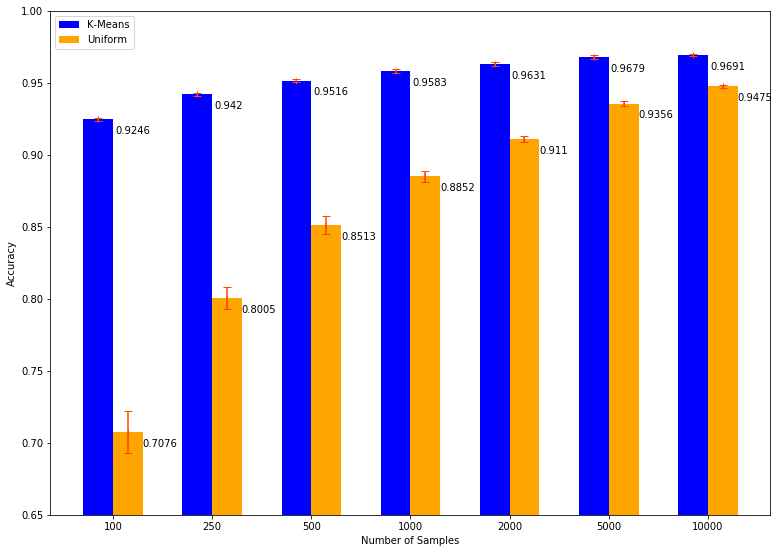

In [63]:
#load variables
sample_list = [100,250,500,1000,2000,5000,10000]
x = np.arange(len(sample_list)) 
results = results
fig = plt.figure(figsize = (10,7))
ax = fig.add_axes([1,1,1,1])

proto_avg = []
uni_avg = []
proto_std = []
uni_std = []

for i in range(len(sample_list)):
    
    proto_avg.extend([np.mean(results[i,:,0])])
    proto_std.extend([np.std( results[i,:,0])])
    uni_avg.extend([np.mean(results[i,:,1])])
    uni_std.extend([np.std(results[i,:,1])])
    
    
plt.bar(x-.15,proto_avg,width = .3,color = 'blue',label = 'K-Means')
plt.bar(x+.15,uni_avg,width = .3,color = 'orange',label = 'Uniform')

ax.set_xticklabels([0,100,250,500,1000,2000,5000,10000])  

# avgs
ax.legend(['K-Means','Uniform'],loc = 'upper left')
[ax.text(x[i]+.02,proto_avg[i]-.01, str(np.round(proto_avg[i],4))) for i in range(len(sample_list))]
[ax.text(x[i]+.30,uni_avg[i]-.01, str(np.round(uni_avg[i],4))) for i in range(len(sample_list))]


# std. dev
ax.errorbar(x-.15, proto_avg, yerr=proto_std,fmt = '|', ecolor='orangered',
            color='orangered', capsize=4)

ax.errorbar(x+.15, uni_avg, yerr=uni_std,fmt = '|', ecolor='orangered',
            color='orangered', capsize=4)

# [ax.text(x[i]-.15,proto_avg[i]+.01, str(np.round(proto_std[i],4))) for i in range(len(sample_list))]
# [ax.text(x[i]+.15,uni_avg[i]+.01, str(np.round(uni_std[i],4))) for i in range(len(sample_list))]


ax.set_ylim([.65,1])
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

print(sample_list[i])
#     print(np.round(proto_avg_acc,4),proto_avg_std)
print(len(sample_list))
plt.show()

In [65]:
import pandas as pd
delta = [l - k for l,k in zip(proto_avg,uni_avg)]

In [66]:
delta

[0.21696999999999989,
 0.14146000000000014,
 0.10023999999999977,
 0.07311000000000001,
 0.05206999999999995,
 0.03229000000000015,
 0.021630000000000038]

In [67]:
data_dict = {'K-Means Accuracy':proto_avg,'K-Means Std. Dev': proto_std, 'Uniform Accuracy': uni_avg,'Uniform Std. Dev'\
            : uni_std,'Accuracy Delta':delta}
k = pd.DataFrame(data = data_dict)
k.index = [100,250,500,1000,2500,5000,10000]
k.rename_axis('Number of Samples')


,K-Means Accuracy,K-Means Std. Dev,Uniform Accuracy,Uniform Std. Dev,Accuracy Delta
Number of Samples,,,,,
100,0.92457,0.001194,0.70760,0.014407,0.21697
250,0.94200,0.001059,0.80054,0.007568,0.14146
500,0.95157,0.001147,0.85133,0.006486,0.10024
1000,0.95827,0.001336,0.88516,0.003811,0.07311
2500,0.96312,0.001186,0.91105,0.002230,0.05207
5000,0.96786,0.001205,0.93557,0.001456,0.03229
10000,0.96911,0.000616,0.94748,0.001136,0.02163


In [25]:
k

,K-Means Accuracy,K-Means Std. Dev,Uniform Accuracy,Uniform Std. Dev,Accuracy Delta
100,0.92457,0.001194,0.70760,0.014407,0.21697
250,0.94200,0.001059,0.80054,0.007568,0.14146
500,0.95157,0.001147,0.85133,0.006486,0.10024
1000,0.95827,0.001336,0.88516,0.003811,0.07311
2500,0.96312,0.001186,0.91105,0.002230,0.05207
5000,0.96786,0.001205,0.93557,0.001456,0.03229
